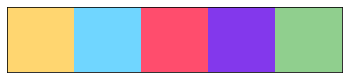

In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections, sys, requests, schedule
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import catboost as cb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)


def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def get_metrics(model, X_eval, y_eval):

    """ calulate metrics """

    pred = model.predict(X_eval)
    pred_prob = model.predict_proba(X_eval)[:, 1]

    d= {}

    d['accuracy'] = accuracy_score(y_eval, pred)
    d['f1'] = f1_score(y_eval, pred)
    d['auc'] = roc_auc_score(y_eval, pred_prob)

    y_true, y_predprob = y_eval.to_frame('target'), pd.Series(pred_prob, index = y_eval.index).to_frame('prediction')
    d['amex_metric_official'] = amex_metric_official(y_true, y_predprob)

    d['tp'] = ((y_eval==1)&(pred==1)).sum()
    d['tn'] = ((y_eval==0)&(pred==0)).sum()
    d['fp'] = ((y_eval==0)&(pred==1)).sum()
    d['fn'] = ((y_eval==1)&(pred==0)).sum()

    d['importances'] = ser_imp = pd.Series(dict(zip(X_eval.columns, model.feature_importances_))).sort_values(ascending = False)

    return d

def eval_catboost(X_train, y_train, X_eval, y_eval, verbose):

    """ evaluate model """

    cat_features = np.where(X_train.dtypes=='category')[0]

    params_c = {}
    params_c['iterations'] = 100
    params_c['cat_features'] = cat_features
    params_c['od_type'] = 'Iter'
    params_c['od_wait'] = 20  
    params_c['eval_metric'] = 'AUC' 
    params_c['verbose'] = verbose

    model = cb.CatBoostClassifier(**params_c)
    model.fit(X_train, y_train, eval_set = (X_eval, y_eval))    
    best_iter = model.best_iteration_
    return model, best_iter, get_metrics(model, X_eval, y_eval) 

def get_catboost_eval_results(X_train, y_train, X_eval, y_eval):

    """ feature selection and eval results """

    i=1
    while True:

        print('> iter#{}. n_features: {}'.format(i, X_train.shape[1]))

        model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=1)

        mask = model.feature_importances_>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            i+=1
    i = 1       
    while True:

        L_perm_imp = []
        for _ in tqdm.tqdm(range(10)):
            d_perm_imp = permutation_importance(model, X_eval, y_eval, scoring='roc_auc', n_jobs=-1, n_repeats = 1, random_state = _)    
            L_perm_imp.append(d_perm_imp['importances_mean'])
        mean_perm_imp = np.c_[L_perm_imp].mean(0)

        mask = mean_perm_imp>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=0)
            i+=1

    return {
        'iterations':best_iter,        
        'eval_results':d_eval_results
    }

In [2]:
# dir with data
PATH_TO_DATA= 'data'

# seed
SEED = 13

# target key
TARGET_KEY='target'

# customer id key
ID_KEY = 'customer_ID'

DATE_KEY = 'S_2'

# split
TEST_SIZE = .1

# percentiles (10)
PS = np.linspace(2.5, 97.5, 10)

# batch size
BATCH_SIZE = 1000

DEFAULT_VALUE = -999

In [3]:
# train data
df_train = pd.read_feather(os.path.join(PATH_TO_DATA, 'train_data.ftr'))

# drop target, order by date
df_train = df_train.drop(TARGET_KEY, 1).sort_values(DATE_KEY).reset_index(drop = True)

In [4]:
# unique customers
unique_customer_id = df_train[ID_KEY].unique()

# split
id_train, id_eval = train_test_split(unique_customer_id, test_size = TEST_SIZE)

In [5]:
# number
num_features = df_train.select_dtypes('number').columns

# category 
cat_features = df_train.select_dtypes('category').columns

In [6]:
# add date features
df_train['timestamp'] = df_train[DATE_KEY].apply(lambda row: row.timestamp()) / 1e9
date_features = np.array(['timestamp'])

# round timestamp
for i in [1, 2, 3, 4, 5]:
    new_key = f'timestamp__round_{i}'
    df_train[new_key] = df_train['timestamp'].round(i)
    date_features = np.append(date_features, new_key)

# year
df_train['year'] = df_train[DATE_KEY].dt.year
date_features = np.append(date_features, 'year')

# month
df_train['month'] = df_train[DATE_KEY].dt.month
date_features = np.append(date_features, 'month')

# day
df_train['day'] = df_train[DATE_KEY].dt.day
date_features = np.append(date_features, 'day')

# weekday
df_train['weekday'] = df_train[DATE_KEY].dt.weekday
date_features = np.append(date_features, 'weekday')

In [7]:
date_features

array(['timestamp', 'timestamp__round_1', 'timestamp__round_2',
       'timestamp__round_3', 'timestamp__round_4', 'timestamp__round_5',
       'year', 'month', 'day', 'weekday'], dtype='<U18')

In [8]:
# split customers into buckets
unique_id_key = df_train[ID_KEY].value_counts().index
l_batches = np.array_split(unique_id_key, np.int32(np.ceil(len(unique_id_key) / BATCH_SIZE)))

# maximum amount of records for each customer
max_group_size = df_train[ID_KEY].value_counts().max()
num_date_features = np.append(num_features, date_features)

d_feature_name = {}
for key in num_date_features:    
    d_feature_name[key] = [f'{key}__ts_{i+1}' for i in range(max_group_size)]

def add_rows(subdf, max_group_size, num_features):
    ''' pad data for customer to max records size'''
    size = subdf.shape[0]
    df_add = pd.DataFrame(np.full((max_group_size-size, len(num_features)), np.nan), columns = num_features)    
    return df_add

In [9]:
df_features_train = pd.DataFrame()

# for each batch
for batch in tqdm.tqdm_notebook(l_batches):

    # subset
    df = df_train[df_train[ID_KEY].isin(batch)]

    # add features
    rows = []
    for id, subdf in tqdm.tqdm_notebook(df.groupby(ID_KEY)):

        # pad customer
        subdf_padded = pd.concat([add_rows(subdf, max_group_size, num_date_features), subdf[num_date_features]])

        # features
        d = {ID_KEY:id}
        d.update(subdf[cat_features].iloc[0].to_dict())

        # number
        for key in num_date_features:

            feature_values = subdf_padded[key].values
            feature_names = d_feature_name[key]

            d.update(dict(zip(feature_names, feature_values)))
            del feature_names, feature_values            

        s = pd.Series(d)
        # agg number
        for key in num_date_features:

            try:

                feature_names = d_feature_name[key]
                feature_values = s[feature_names]

                d[f'{key}__mean'] = feature_values.mean()
                d[f'{key}__sum'] = feature_values.sum()
                d[f'{key}__min'] = feature_values.min()
                d[f'{key}__max'] = feature_values.max()
                d[f'{key}__nan_mean'] = feature_values.isna().mean()
                d[f'{key}__diff_mean'] = feature_values.fillna(0).diff().mean()

            except:
                pass
        
        rows.append(d)
        del d, s, subdf_padded, subdf

    # features subset
    subdf_features = pd.DataFrame.from_records(rows)
    del rows

    # add
    df_features_train = df_features_train.append(subdf_features)
    del subdf_features 

    break  

# add binning
for key in tqdm.tqdm(d_feature_name.keys()):
    try:
        feature_names = d_feature_name[key]
        arr = pd.Series(df_features_train[feature_names].values.flatten()).dropna().values
        bins = np.unique(np.percentile(arr, PS))
        df_features_train = pd.concat([df_features_train, df_features_train[feature_names].applymap(lambda x: np.abs(bins-x).argmin()).add_suffix('__bin')], 1)
        del arr
    except:
        pass

df_features_train = df_features_train.sort_values(ID_KEY).set_index(ID_KEY)

# cat
df_features_train[cat_features] = df_features_train[cat_features].astype('object').fillna('default').astype('str').astype('category')

# num binned
bin_features = df_features_train.columns[df_features_train.columns.str.contains('__bin')]
df_features_train[bin_features] = df_features_train[bin_features].astype('str').astype('category')

# num
num_features = df_features_train.select_dtypes('number').columns
df_features_train[num_features] = df_features_train[num_features].fillna(DEFAULT_VALUE)

# scale num
scaler = MinMaxScaler()
for key in tqdm.tqdm(num_features):
    df_features_train[key] = scaler.fit_transform(df_features_train[[key]]).flatten()

assert df_features_train.isna().any().any()==False

df_features_train.to_pickle('df_features_train.pickle')

  0%|          | 0/459 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]